# Finding bigfoot (partie 2)

Ce bloc de code charge toutes les dépendances du projet. Ne le modifiez pas!

In [2]:
import Pkg; Pkg.activate(pwd())
_code_path = joinpath(dirname(Base.active_project()), "code")
modules = ["pkg", "palettes", "confusionmatrix", "mocks", "crossvalidation", "pipelines", "nbc", "variableselection", "transformations", "bootstrap"]
for m in modules
    include(joinpath(_code_path, "$(m).jl"))
end

  Activating project at `~/Code/BigFoot`


## Chargement des données

On charge maintenant les données d'entraînement du modèle:

In [3]:
JLD2.jldopen("training.jld2", "r") do file
    global X = file["X"]
    global y = file["y"]
end;
presences = findall(y);
absences = findall(.!y);

Visualisation des classes présence/absence en fonction de deux variables:

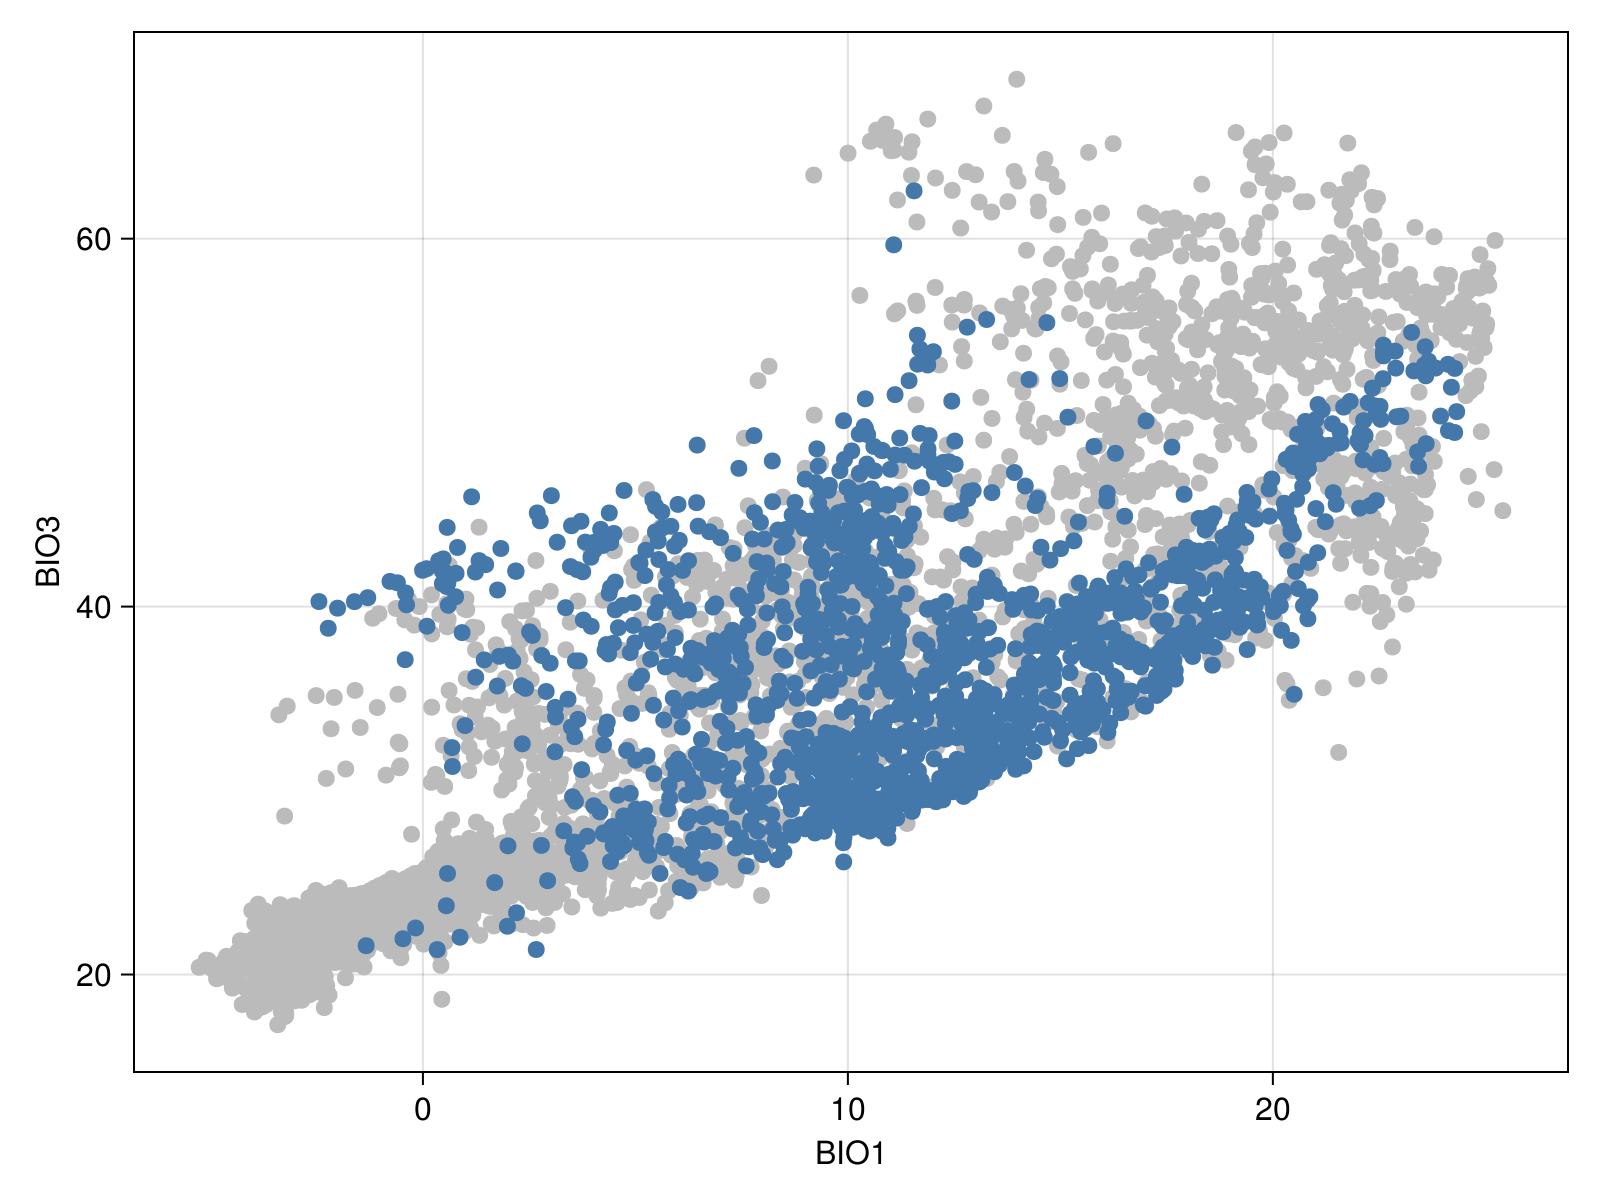

In [4]:
fig = Figure()
ax = Axis(fig[1,1]; xlabel="BIO1", ylabel="BIO3")

scatter!(ax, X[1,absences], X[3,absences], color=bright[1])
scatter!(ax, X[1,presences], X[3,presences], color=bright[2])

current_figure()

On peut "entraîner" un classificateur *no-skill* et *coin flip* pour évaluer leur performance:

In [5]:
Cnoskill = noskill(y)
Ccoinflip = coinflip(y)

ConfusionMatrix{Float64}(0.1664582030435689, 0.1664582030435689, 0.3335417969564311, 0.3335417969564311)

Quelle est la performance attendue du classificateur *no-skill*? On peut utiliser différentes fonctiones: `mcc`, `ppv`, `npv`, `trueskill`, `tpr`, `fpr`, `tnr`, `fnr`, `accuracy`, *etc.*. Expérimentez avec la matrice `Cnoskill` et `Ccoinflip` en adaptant le code ci-dessous (et gardez une trace de vos résultats!):

In [6]:
mcc(Cnoskill)

3.1244587087436436e-17

La valeur de MCC pour *no skill* est proche de zéro -- est-ce que c'est le résultat attendu?

## Stratégie de validation croisée

Vous devrez choisir une méthode de validation croisée. Toutes les méthodes utilisent la même interface (vous n'aurez pas besoin de modifier votre code selon la méthode utilisée, mais ne changez pas le nom de la variable `splits`), mais vous devrez expérimenter avec plusieurs méthodes pour obtenir la meilleure évaluation de la performance du modèle:

In [7]:
splits = kfold(y, X; k=20); # k-folds, k est le nombre de folds
#splits = montecarlo(y, X; n=50, proportion=0.1); # Monte-Carlo, n est le nombre de sous-ensembles, et on peut choisir la proportion des données de validation
#splits = [holdout(y, X; proportion=0.2)]; # Un seul holdout

20-element Vector{Any}:
 ([3337, 3040, 72, 1579, 2226, 3241, 893, 2736, 2705, 1531  …  4041, 2823, 4426, 4243, 1159, 283, 4306, 4242, 870, 4670], [2365, 115, 2360, 3071, 3093, 647, 2251, 3720, 2645, 186  …  4552, 2133, 329, 3260, 2824, 1618, 427, 3751, 3367, 474])
 ([2365, 115, 2360, 3071, 3093, 647, 2251, 3720, 2645, 186  …  4041, 2823, 4426, 4243, 1159, 283, 4306, 4242, 870, 4670], [3337, 3040, 72, 1579, 2226, 3241, 893, 2736, 2705, 1531  …  2075, 2539, 4238, 65, 4515, 7, 57, 1090, 746, 1475])
 ([2365, 115, 2360, 3071, 3093, 647, 2251, 3720, 2645, 186  …  4041, 2823, 4426, 4243, 1159, 283, 4306, 4242, 870, 4670], [795, 2252, 332, 135, 4523, 2634, 2790, 1267, 3109, 4613  …  3293, 2222, 511, 2553, 1364, 4290, 1182, 1683, 1448, 3373])
 ([2365, 115, 2360, 3071, 3093, 647, 2251, 3720, 2645, 186  …  4041, 2823, 4426, 4243, 1159, 283, 4306, 4242, 870, 4670], [2087, 2491, 2098, 1260, 4257, 3170, 1269, 2745, 4749, 446  …  2779, 2891, 3596, 833, 2952, 3525, 2719, 38, 2682, 4232])
 ([2365, 115,

## Entraînement d'un modèle avec deux variables

Dans le cadre de ce projet, un modèle se compose d'une transformation (aucune par défaut), d'un classificateur (nous allons utiliser NBC), et d'un seuil:

In [16]:
# Transformations possibles:
# - ZScore
# - RawData
# - MultivariateTransform{Whitening}
# - MultivariateTransform{PCA}
model = SDM(MultivariateTransform{PCA}(), NBC(), Thresholder())

SDM(MultivariateTransform{PCA}(PCA(indim = 5, outdim = 4, principalratio = 1.0)), NBC(Normal[], Normal[], 0.5), Thresholder{Float64}(0.5))

Nous allons utiliser deux variables: température et précipitation.

In [17]:
variables = [1,12]

2-element Vector{Int64}:
  1
 12

Au début, les paramètres du modèle ne sont pas initialisés. On va devoir effectuer une étape d'entraînement:

In [18]:
train!(model, y, X[variables,:])

SDM(MultivariateTransform{PCA}(PCA(indim = 2, outdim = 1, principalratio = 0.99968344)), NBC(Normal[Normal{Float32}(μ=318.35156f0, σ=428.14313f0)], Normal[Normal{Float32}(μ=-158.87752f0, σ=370.36823f0)], 0.5), Thresholder{Float64}(0.5387763908061116))

Remarquez que par défaut, le modèle va optimiser le seuil. On peut vérifier le seuil avec `model.threshold.cutoff` -- le seuil est automatiquement choisi pour maximiser le MCC.

Dans la pratique, au lieu d'entraîner notre modèle avec toutes les données, on veut effectuer une validation croissée pour mieux comprendre sa performance. La fonction `crossvalidate` renvoie une série de matrices de confusion, pour les données de validation et pour les données d'entraînement:

In [19]:
Cv, Ct = crossvalidate(model, y, X[variables,:], splits; classify=true)

(ConfusionMatrix[ConfusionMatrix{Int64}(54, 131, 22, 34), ConfusionMatrix{Int64}(62, 128, 29, 21), ConfusionMatrix{Int64}(48, 154, 20, 17), ConfusionMatrix{Int64}(50, 143, 23, 24), ConfusionMatrix{Int64}(61, 137, 18, 24), ConfusionMatrix{Int64}(68, 135, 23, 14), ConfusionMatrix{Int64}(53, 143, 18, 26), ConfusionMatrix{Int64}(60, 125, 24, 30), ConfusionMatrix{Int64}(60, 129, 26, 25), ConfusionMatrix{Int64}(56, 127, 26, 31), ConfusionMatrix{Int64}(54, 140, 25, 21), ConfusionMatrix{Int64}(48, 143, 30, 19), ConfusionMatrix{Int64}(58, 131, 26, 24), ConfusionMatrix{Int64}(58, 134, 24, 24), ConfusionMatrix{Int64}(48, 146, 18, 28), ConfusionMatrix{Int64}(61, 132, 26, 21), ConfusionMatrix{Int64}(49, 144, 19, 28), ConfusionMatrix{Int64}(47, 145, 15, 32), ConfusionMatrix{Int64}(41, 128, 27, 44), ConfusionMatrix{Int64}(54, 135, 31, 20)], ConfusionMatrix[ConfusionMatrix{Int64}(1024, 2630, 417, 485), ConfusionMatrix{Int64}(1048, 2597, 446, 466), ConfusionMatrix{Int64}(1062, 2571, 455, 470), Confusio

On peut visualiser le résultat de la validation croisée. Nous allons représenter les résultats de chaque split, en montrant à la fois les données d'entraînement (gris) et de validation (orange), pour vérifier que la performance sur les deux jeux de données est comparable.

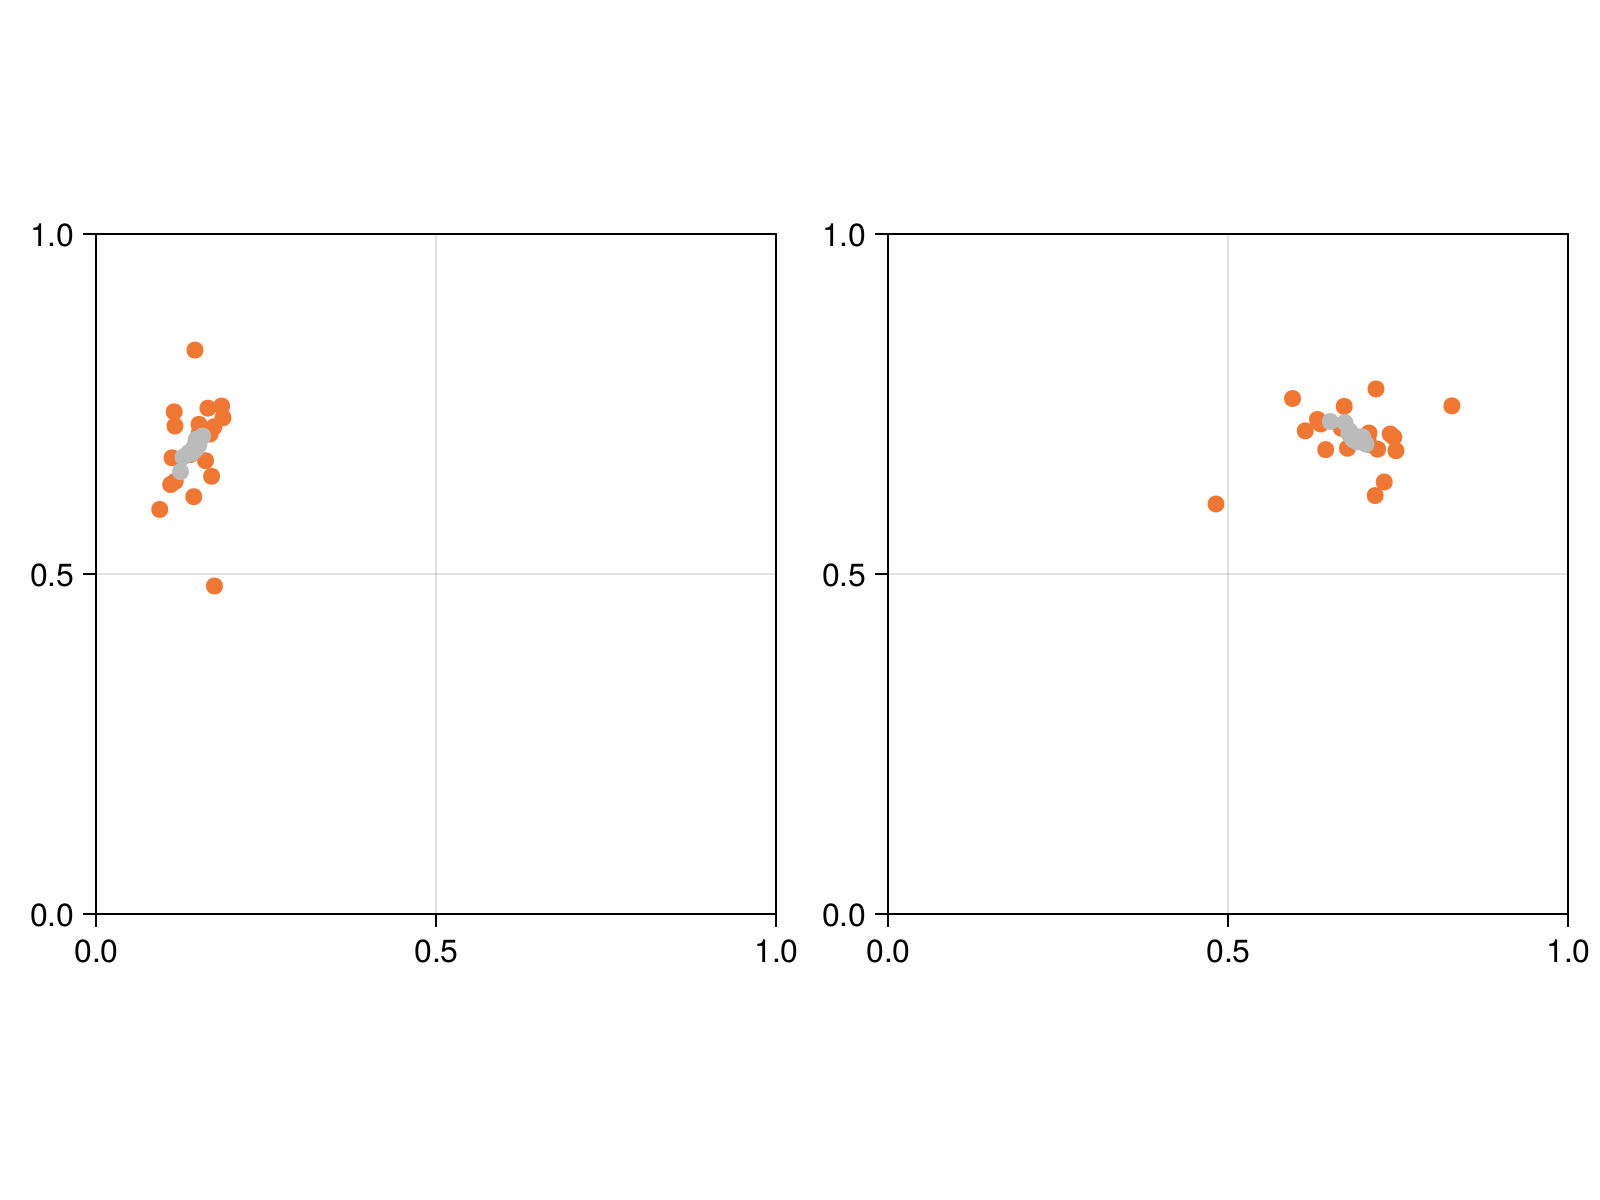

In [20]:
fig = Figure()
ax_roc = Axis(fig[1,1]; aspect=DataAspect())
ax_pr = Axis(fig[1,2]; aspect=DataAspect())

scatter!(ax_roc, fpr.(Cv), tpr.(Cv); color=vibrant[2])
scatter!(ax_roc, fpr.(Ct), tpr.(Ct); color=vibrant[1])

scatter!(ax_pr, tpr.(Cv), ppv.(Cv); color=vibrant[2])
scatter!(ax_pr, tpr.(Ct), ppv.(Ct); color=vibrant[1])

for ax in [ax_roc, ax_pr]
    xlims!(ax, 0., 1.)
    ylims!(ax, 0., 1.)
end

current_figure()

On peut maintenant rapporter le MCC moyen de notre modèle:

In [21]:
mean(mcc.(Cv))

0.539807920937412

Prenez du temps pour décrire le comportement du modèle, en utilisant par exemple PPV et NPV -- gardez une note de vos résultats.

## Sélection des variables

Dans cette section, nous allons examiner la sélection des variables. Notez que la sélection des variables fait aussi la validation croisée!

In [22]:
#variables = [1,12] # Sélection manuelle
variables = constrainedselection(model, y, X, splits, variables, mcc; classify=true)
#variables = forwardselection(model, y, X, splits, mcc; classify=true)
#variables = backwardselection(model, y, X, splits, mcc; classify=true)

┌ Info: N = 3
└ @ Main /home/tpoisot/Code/BigFoot/code/variableselection.jl:27
┌ Info: N = 4
└ @ Main /home/tpoisot/Code/BigFoot/code/variableselection.jl:27


┌ Info: N = 5
└ @ Main /home/tpoisot/Code/BigFoot/code/variableselection.jl:27
┌ Info: Returning with [1, 12, 4, 17] -- 0.6958471093192106
└ @ Main /home/tpoisot/Code/BigFoot/code/variableselection.jl:39


4-element Vector{Int64}:
  1
 12
  4
 17

On peut maintenant faire la validation croisée du modèle avec les meilleures variables. Adaptez le code des exemples précédents pour mesurer la performance du modèle:

In [23]:
Cv, Ct = crossvalidate(model, y, X[variables,:], splits; classify=true)

(ConfusionMatrix[ConfusionMatrix{Int64}(73, 126, 27, 15), ConfusionMatrix{Int64}(74, 136, 21, 9), ConfusionMatrix{Int64}(59, 154, 20, 6), ConfusionMatrix{Int64}(66, 145, 21, 8), ConfusionMatrix{Int64}(74, 134, 21, 11), ConfusionMatrix{Int64}(76, 137, 21, 6), ConfusionMatrix{Int64}(68, 139, 22, 11), ConfusionMatrix{Int64}(77, 125, 24, 13), ConfusionMatrix{Int64}(72, 130, 25, 13), ConfusionMatrix{Int64}(72, 130, 23, 15), ConfusionMatrix{Int64}(71, 140, 25, 4), ConfusionMatrix{Int64}(58, 148, 25, 9), ConfusionMatrix{Int64}(75, 134, 23, 7), ConfusionMatrix{Int64}(73, 130, 28, 9), ConfusionMatrix{Int64}(63, 138, 26, 13), ConfusionMatrix{Int64}(74, 137, 21, 8), ConfusionMatrix{Int64}(60, 140, 23, 17), ConfusionMatrix{Int64}(64, 138, 22, 15), ConfusionMatrix{Int64}(72, 124, 31, 13), ConfusionMatrix{Int64}(62, 145, 21, 12)], ConfusionMatrix[ConfusionMatrix{Int64}(1307, 2600, 447, 202), ConfusionMatrix{Int64}(1304, 2597, 446, 210), ConfusionMatrix{Int64}(1323, 2575, 451, 209), ConfusionMatrix{I

## Entraînement du modèle avec les variables finales

In [24]:
train!(model, y, X[variables,:])

SDM(MultivariateTransform{PCA}(PCA(indim = 4, outdim = 2, principalratio = 0.9923792)), NBC(Normal[Normal{Float32}(μ=340.56552f0, σ=442.49814f0), Normal{Float32}(μ=61.757084f0, σ=163.14899f0)], Normal[Normal{Float32}(μ=-169.96356f0, σ=364.77713f0), Normal{Float32}(μ=-30.82107f0, σ=339.74222f0)], 0.5), Thresholder{Float64}(0.384124760482371))

## Prédictions avec le modèle

In [25]:
predictors = [SpeciesDistributionToolkit._read_geotiff("layers.tiff", SimpleSDMPredictor; bandnumber=v) for v in variables]

4-element Vector{SimpleSDMPredictor{Float32}}:
 SDM predictor → 720×1440 grid with 769931 Float32-valued cells
 SDM predictor → 720×1440 grid with 769931 Float32-valued cells
 SDM predictor → 720×1440 grid with 769931 Float32-valued cells
 SDM predictor → 720×1440 grid with 769931 Float32-valued cells

Prédiction du modèle:

In [26]:
prediction = similar(predictors[1])
Threads.@threads for k in keys(prediction)
    input = [predictor[k] for predictor in predictors]
    prediction[k] = predict(model, input; classify=false)
end

Données des observations (source: *trust me, bro*):

In [27]:
sightings = map(x -> tuple(reverse(parse.(Float64, x))...), split.(readlines("occurrences.csv"), ','))
filter!(r -> 25 <= r[2] <= 55, sightings);
filter!(r -> -130 <= r[1] <= -70, sightings);

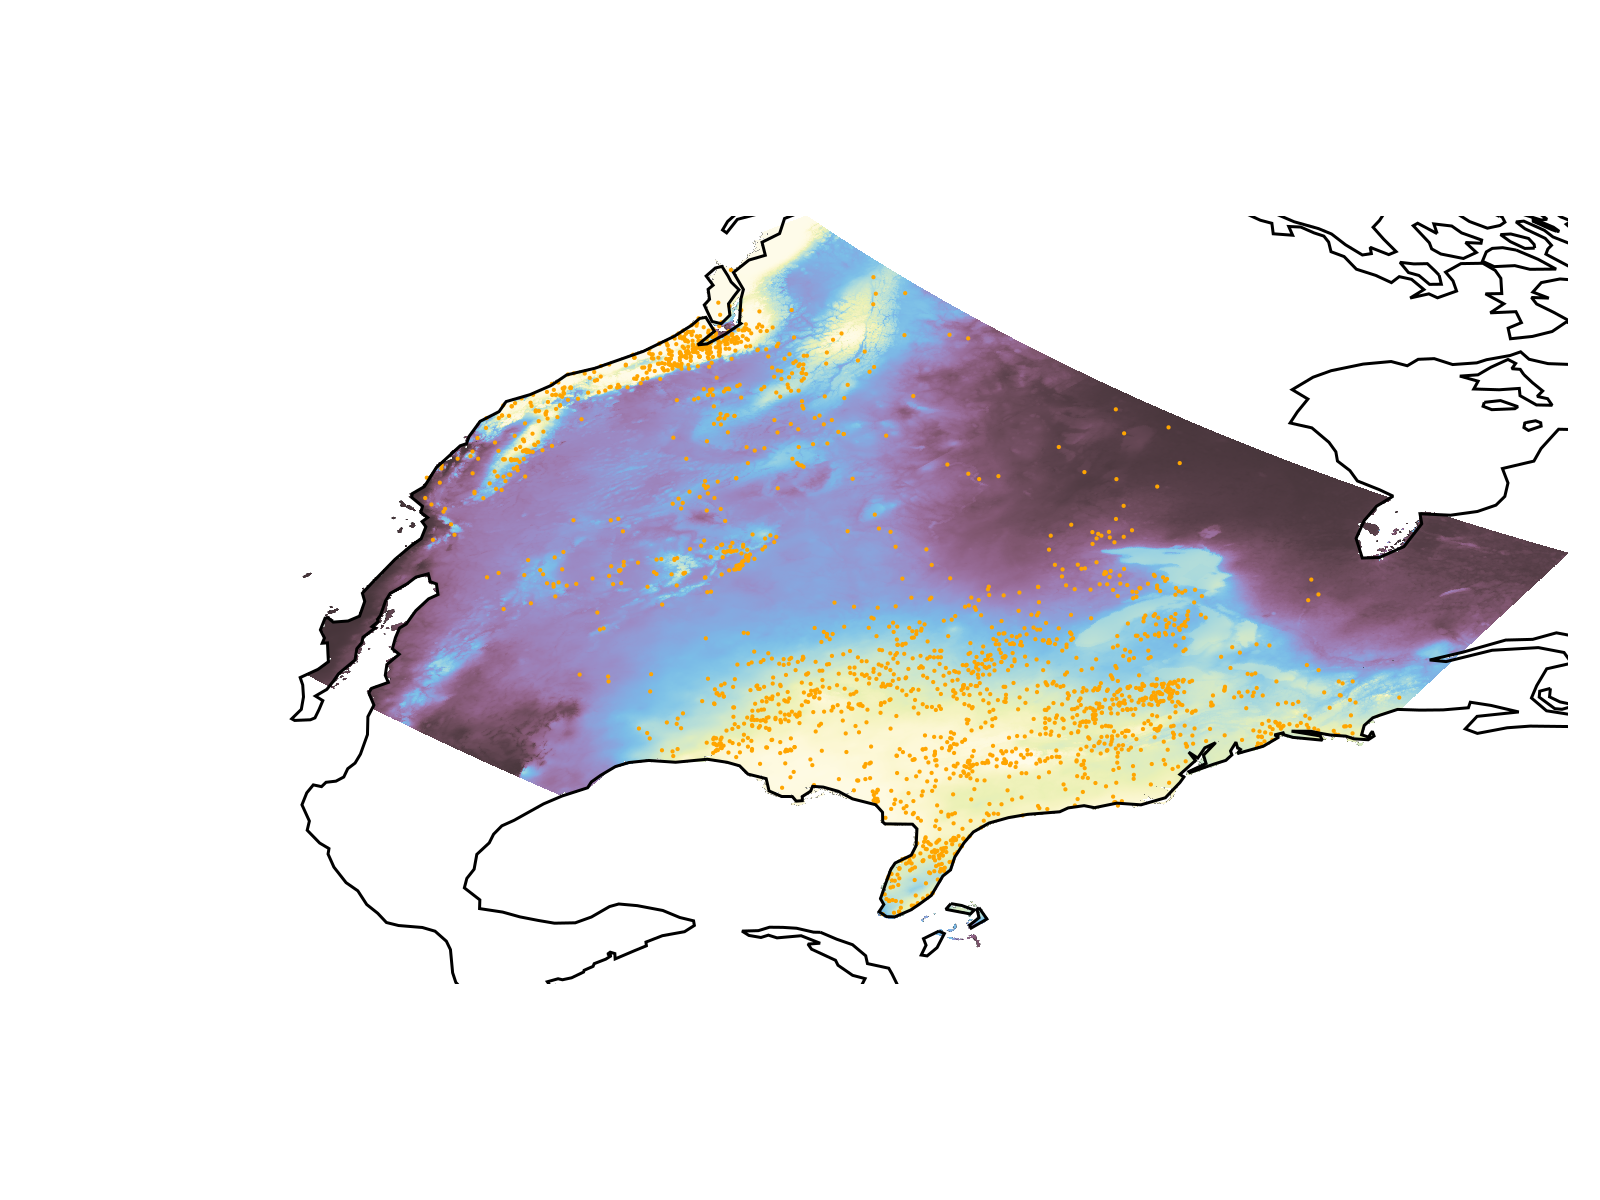

In [53]:
fig = Figure()
ax = GeoMakie.GeoAxis(fig[1,1]; dest = "+proj=aea +lat_1=0.0 +lat_2=55.0", coastlines=true, lonlims=extrema(longitudes(prediction)), latlims=extrema(latitudes(prediction)))
surface!(ax, prediction, colormap=reverse(cgrad(iridescent)); shading=false)
scatter!(ax, sightings, color=:orange, markersize=3)
hidedecorations!(ax)
hidespines!(ax)
current_figure()

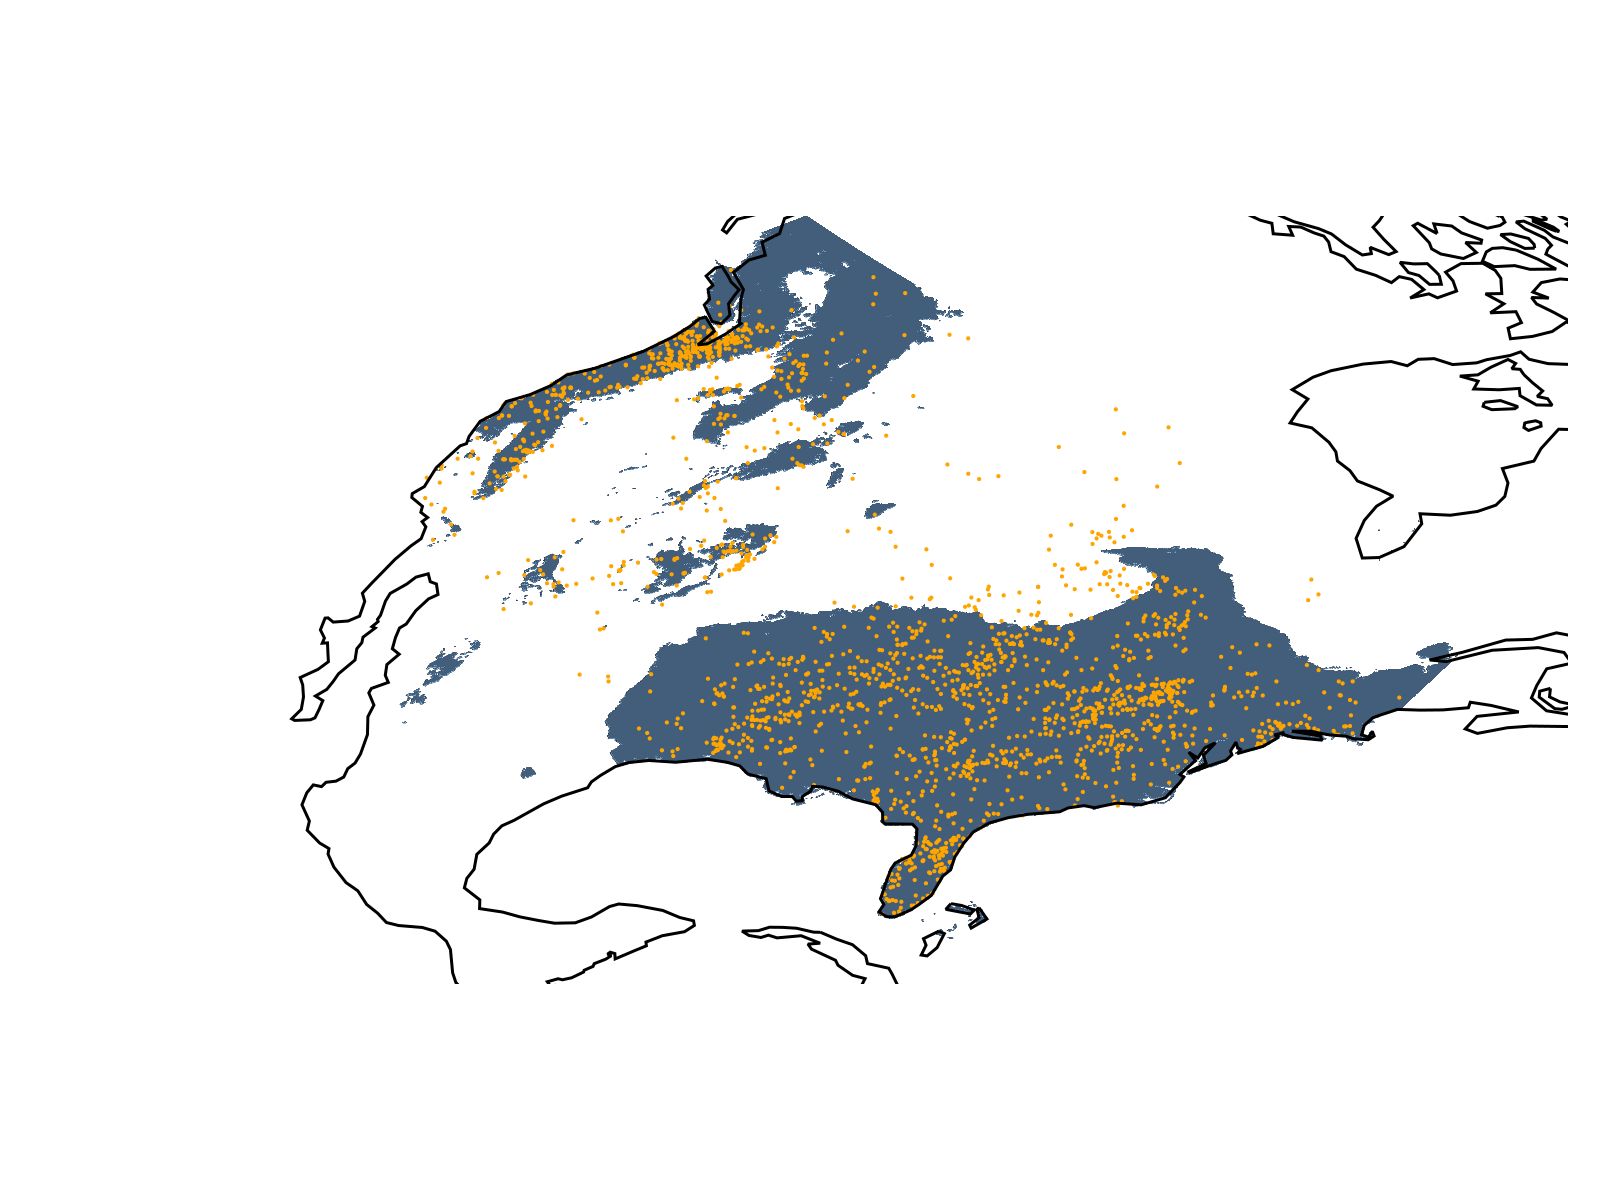

In [57]:
fig = Figure()
ax = GeoMakie.GeoAxis(fig[1,1]; dest = "+proj=aea +lat_1=0.0 +lat_2=55.0", coastlines=true, lonlims=extrema(longitudes(prediction)), latlims=extrema(latitudes(prediction)))
surface!(ax, replace(prediction .>= model.threshold.cutoff, false => nothing), colormap=[light[2]]); shading=false
scatter!(ax, sightings, color=:orange, markersize=3)
hidedecorations!(ax)
hidespines!(ax)
current_figure()

## Bagging

In [30]:
bags = bootstrap(y, X; n=10)
ensemble = Bagging(model, bags)
train!(ensemble, y, X[variables,:])

Bagging(SDM(MultivariateTransform{PCA}(PCA(indim = 4, outdim = 2, principalratio = 0.9923792)), NBC(Normal[Normal{Float32}(μ=340.56552f0, σ=442.49814f0), Normal{Float32}(μ=61.757084f0, σ=163.14899f0)], Normal[Normal{Float32}(μ=-169.96356f0, σ=364.77713f0), Normal{Float32}(μ=-30.82107f0, σ=339.74222f0)], 0.5), Thresholder{Float64}(0.384124760482371)), [([1744, 4272, 2444, 2276, 2631, 4674, 3216, 886, 52, 4405  …  1655, 2471, 3991, 3486, 3675, 4178, 642, 784, 645, 2607], [2, 8, 12, 15, 17, 25, 27, 30, 33, 35  …  4765, 4770, 4772, 4773, 4777, 4778, 4779, 4792, 4796, 4797]), ([3369, 903, 4699, 1852, 3501, 196, 740, 246, 3305, 3255  …  3857, 2090, 119, 3293, 3146, 854, 177, 3410, 342, 1512], [1, 3, 5, 8, 10, 12, 13, 19, 20, 21  …  4769, 4772, 4777, 4783, 4785, 4788, 4789, 4790, 4791, 4794]), ([4621, 3403, 2551, 2274, 1422, 396, 3549, 4144, 4017, 4048  …  500, 1957, 1676, 3422, 4085, 1382, 2257, 2878, 4341, 70], [4, 5, 7, 10, 11, 18, 22, 23, 25, 26  …  4773, 4776, 4777, 4778, 4780, 4781, 478

On va mesurer l'incertitude avec l'écart interquartile, *i.e.* la différence entre les quartiles 25% et 75%:

In [31]:
function iqr(x)
    if all(isnan.(x))
        return 0.0
    else
        return first(diff(quantile(filter(!isnan, x), [0.25, 0.75])))
    end
end

iqr (generic function with 1 method)

In [34]:
uncertainty = similar(predictors[1])
Threads.@threads for k in keys(prediction)
    input = [predictor[k] for predictor in predictors]
    uncertainty[k] = predict(ensemble, input; consensus=iqr, classify=false)
end

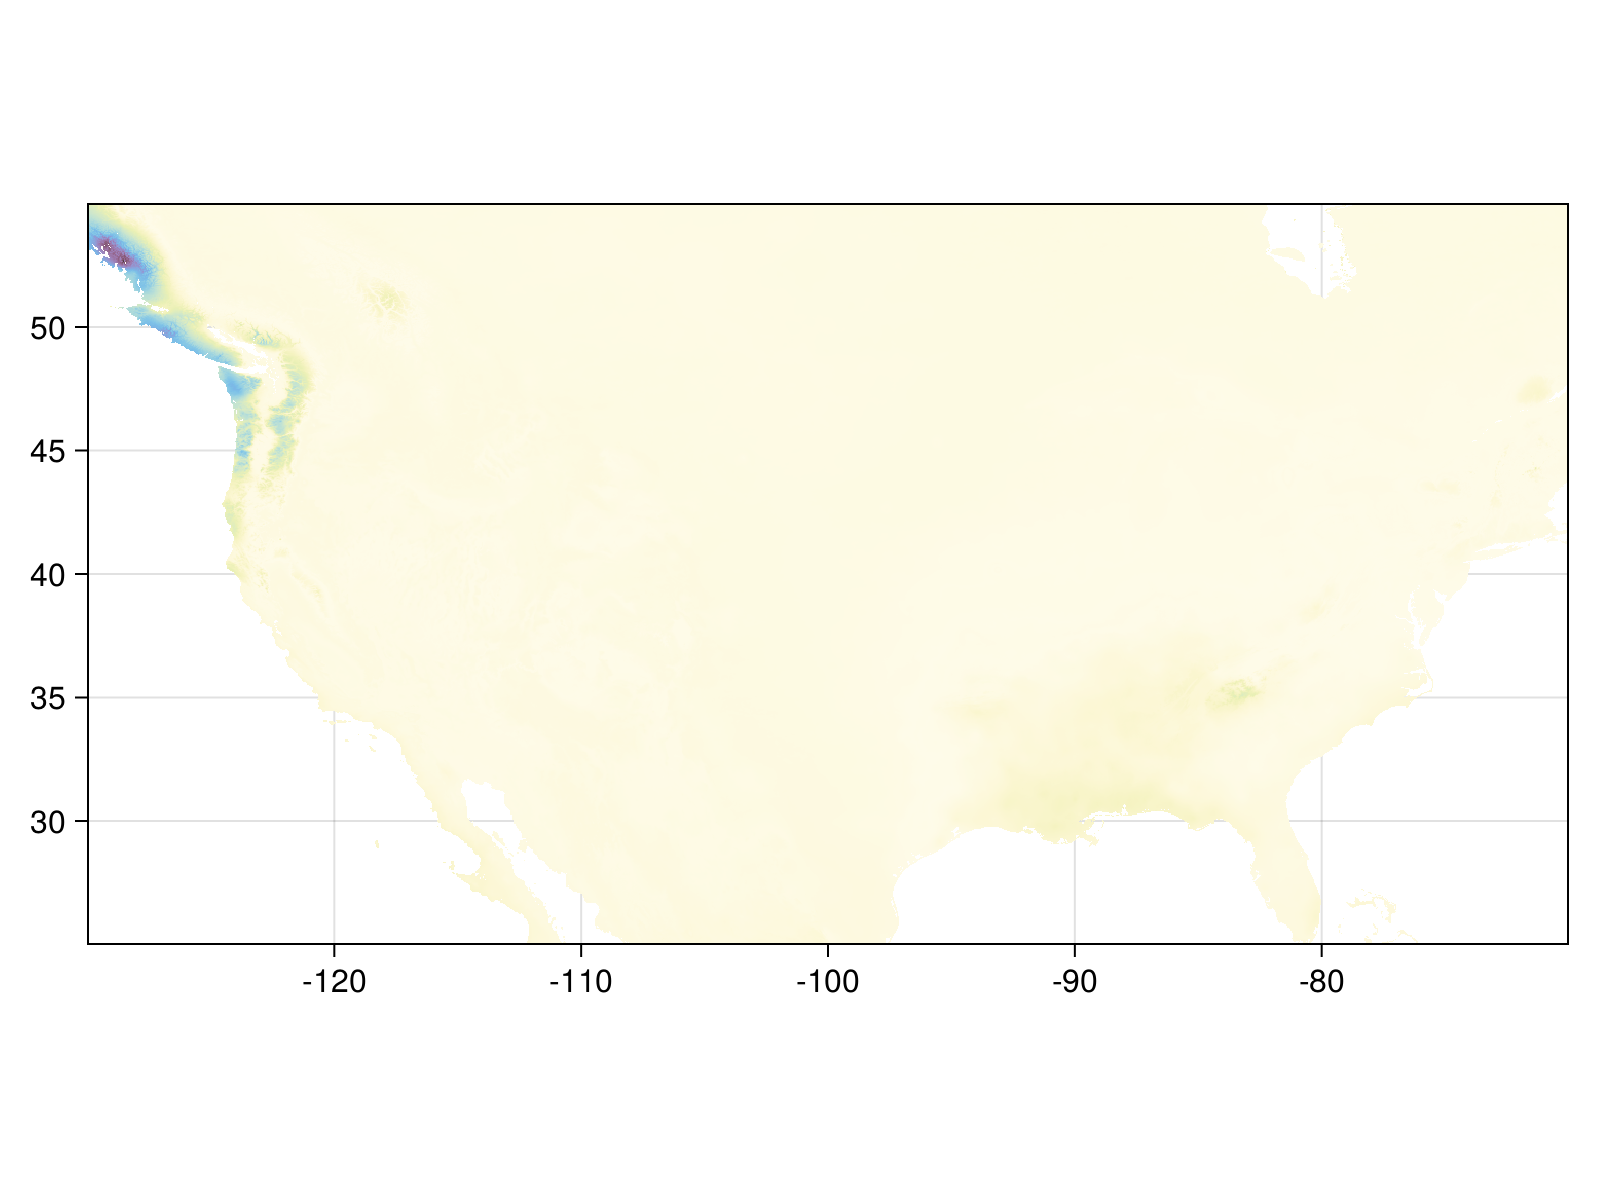

In [35]:
fig = Figure()
ax = Axis(fig[1,1]; aspect=DataAspect())
heatmap!(ax, uncertainty, colormap=cgrad(iridescent))
current_figure()